### Can tidal forces and the Lidov-Kozai mechanism cause a system of exomoons to align in the same orbital plane?

This script creates a system of the Sun + Jupiter + the Galilean moons, and runs a gravity code on them to investigate the moons change of eccentricity and inclination due to the Lidov-Koszai effect. 

The script is designed such that you can tell it which moons you'd like to include.

In [1]:
# Packages
import time
import numpy as np
from amuse.lab import Particles
import matplotlib.pyplot as plt
from amuse.units.constants import G
from amuse.units import units, constants
from amuse.lab import Huayno, nbody_system
from amuse.community.ph4.interface import ph4
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

In [2]:
''' Function to create our particle system.
    Input: list of Galileann Moon names in string format (any combination of: io, europa, ganymede, callisto)
    Returns: Particle system 
    Example: system = system_with_moons(moons=['io', 'europa']) ''';

def system_with_moons(moons, *args):
    
    
    # Initialising Sun and Jupiter
    Msun = 1.0|units.MSun
    Mjup = 1.0|units.MJupiter
    a_jup = 5.2|units.au
    e_jup = 0.0
    
    system = new_binary_from_orbital_elements(Msun, Mjup, a_jup, e_jup, G=constants.G)
    system[0].name = 'sun'
    system[1].name = 'jupiter'
    jupiter = system[system.name=='jupiter']
    jupiter.semimajor_axis = a_jup
    
    
    # Function to automate addition of particles
    def add_particle(particle, a, e, inc, m):
        
        binary = new_binary_from_orbital_elements(jupiter.mass, m, a, eccentricity=e, inclination=inc, G=constants.G)
         
        system.add_particle(binary[1].as_set()) 
        system[-1].name = particle
        moon = system[system.name==particle] 
        
        moon.semimajor_axis = a
        moon.inclination = inc
        moon.position = binary[1].position + jupiter.position
        moon.velocity = binary[1].velocity + jupiter.velocity
        
        system.move_to_center()
    
    
    # Add moons based on input
    if 'io' in moons:
        a = 421800|units.km
        e = 0.6
        inc = 60|units.deg
        m = 8.93E22|units.kg
        add_particle('io', a, e, inc, m) 
    
    if 'europa' in moons:
        a = 671100|units.km
        e = 0.5
        inc = 55|units.deg
        m = 4.80E22|units.kg
        add_particle('europa', a, e, inc, m)  

    if 'ganymede' in moons:
        a = 1070400|units.km
        e = 0.4
        inc = 50|units.deg
        m = 1.48E23|units.kg
        add_particle('ganymede', a, e, inc, m)   
        
    if 'callisto' in moons:
        a = 1882700|units.km
        e = 0.3
        inc = 45|units.deg
        m = 1.08E23|units.kg
        add_particle('callisto', a, e, inc, m)  
        
    print('Particle system created for: '+ str(system.name))
    return system

In [3]:
# Testing
moons = ['io', 'europa', 'ganymede', 'callisto']
system = system_with_moons(moons=moons)

Particle system created for: ['sun' 'jupiter' 'io' 'europa' 'ganymede' 'callisto']


In [4]:
''' Function to integrate the system over time using a gravity code.
    Input: list of Galileann Moon names in string format (any combination (but in order!) of: io, europa, ganymede, callisto),
            integration time step, time range for integration
    Returns: list of evolved eccentrities, list of evolved inclinations, time range at time step intervals
    Example: ecc, inc, time_range = integrate_system(moons=['io', 'callisto'], 10|units.yr, 1000|units.yr) ''';

def integrate_system(moons, dt, end_time):
    
    # Checking how long code takes to run
    start_time = time.time()
    
    # Getting system
    system = system_with_moons(moons=moons)
    
    # Converting Nbody
    converter = nbody_system.nbody_to_si(system.mass.sum(), system[1].position.length())
    
    # Gravity code
    gravity = Huayno(converter)
    gravity.particles.add_particles(system)
    
    # Eccentricities
    e_io = []
    e_eu = []
    e_ga = []
    e_ca = []
    
    # Inclinations
    i_io = [] | units.deg
    i_eu = [] | units.deg
    i_ga = [] | units.deg
    i_ca = [] | units.deg
    
    # Integration period
    time_range = [] | units.yr
    
    # Channel
    channel = gravity.particles.new_channel_to(system)
    
    
    # Running gravity code
    while gravity.model_time < end_time:
        
        if 'io' in moons:
            orbit_io = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='io')],
                                                        G=constants.G)
            
        if 'europa' in moons:
            orbit_eu = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='europa')],
                                                        G=constants.G)
            
        if 'ganymede' in moons:
            orbit_ga = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='ganymede')],
                                                        G=constants.G)
            
        if 'callisto' in moons:
            orbit_ca = get_orbital_elements_from_binary(system[(system.name=='jupiter')|(system.name=='callisto')],
                                                        G=constants.G)
        
        gravity.evolve_model(gravity.model_time + (dt))
        channel.copy()
        
        if 'io' in moons:
            e_io.append(orbit_io[3])
            i_io.append(orbit_io[5])
        
        if 'europa' in moons:
            e_eu.append(orbit_eu[3])
            i_eu.append(orbit_eu[5])
        
        if 'ganymede' in moons:
            e_ga.append(orbit_ga[3])
            i_ga.append(orbit_ga[5])
        
        if 'callisto' in moons:
            e_ca.append(orbit_ca[3])
            i_ca.append(orbit_ca[5])
        
        time_range.append(gravity.model_time + (dt))
        
    gravity.stop()
    
    
    ecc = []
    inc = [] | units.deg
    
    if 'io' in moons:
        ecc.append(e_io)
        inc.append(i_io)
        
    if 'europa' in moons:
        ecc.append(e_eu)
        inc.append(i_eu)
        
    if 'ganymede' in moons:
        ecc.append(e_ga)
        inc.append(i_ga)
        
    if 'callisto' in moons:
        ecc.append(e_ca)
        inc.append(i_ca)
        
    
    # Printing runtime
    print('Runtime: %s seconds' % (time.time() - start_time))
    
    
    return ecc, inc, time_range

In [ ]:
# Running code

moons = ['io', 'europa', 'ganymede', 'callisto']
#moons = ['io', 'ganymede']
#moons=['callisto']

ecc, inc, time_range = integrate_system(moons, 10|units.yr, 1000|units.yr)

Particle system created for: ['sun' 'jupiter' 'io' 'europa' 'ganymede' 'callisto']


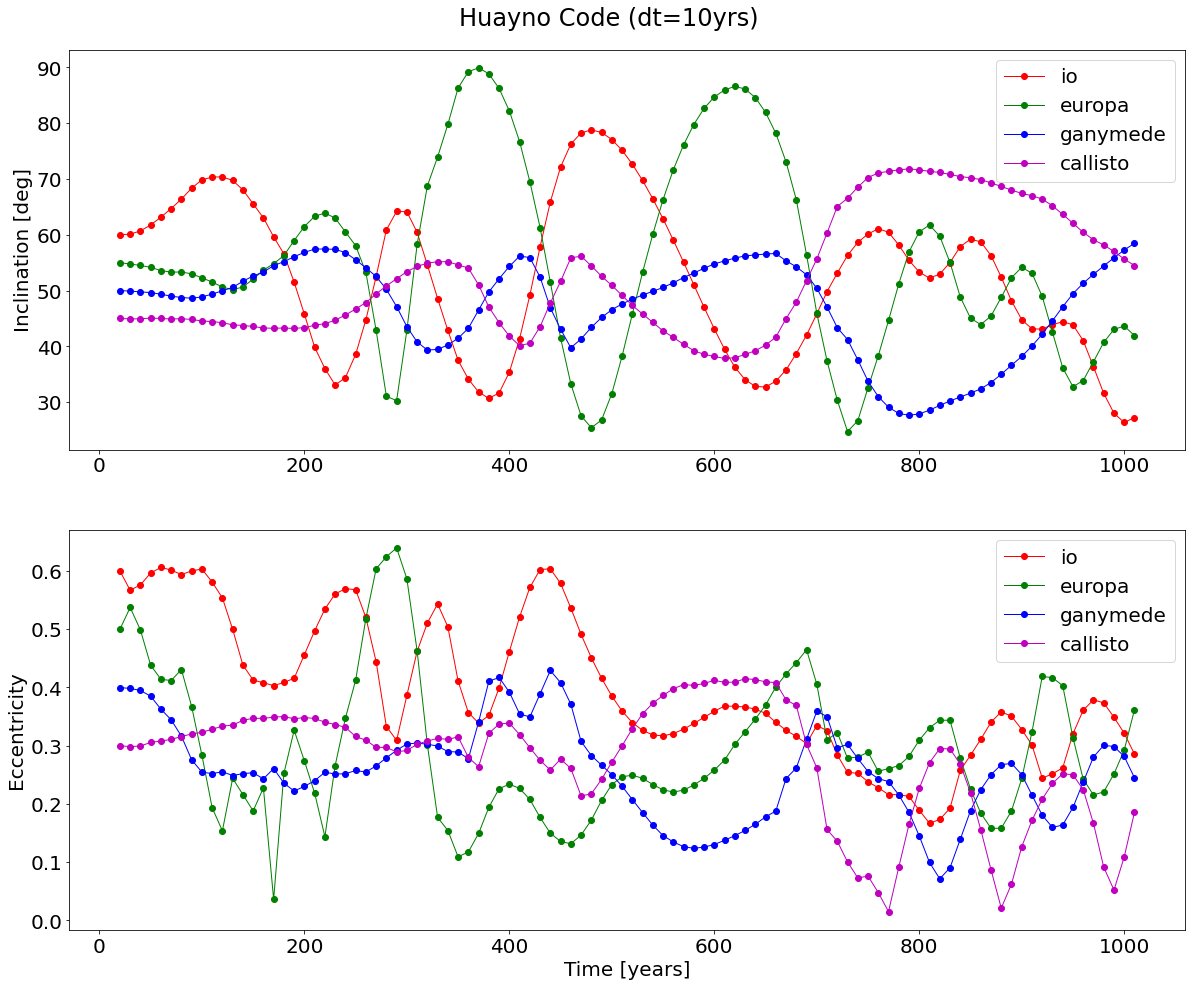

In [6]:
def plot_tracks(moons, ecc, inc, time_range):
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[20, 15])
    colours = ['r', 'g', 'b', 'm']

    for i in range(len(moons)):
        ax1.plot(time_range.value_in(units.yr), inc[i].value_in(units.deg), '-o', color=colours[i], lw=1, label=moons[i])   
    ax1.set_ylabel('Inclination [deg]')
    ax1.legend()

    for i in range(len(moons)):
        ax2.plot(time_range.value_in(units.yr), np.array(ecc[i]), '-o', color=colours[i], lw=1, label=moons[i])   
    ax2.set_ylabel('Eccentricity')
    ax2.set_xlabel('Time [years]')
    ax2.legend()
    
    plt.suptitle('Huayno Code (dt=10yrs)')
    plt.subplots_adjust(top=0.94)
    #plt.savefig('dt10.png', facecolor='w', bbox_inches='tight')
    plt.show()

plot_tracks(moons, ecc, inc, time_range)

In [7]:
''' The Kozai-constant Lz should be (approximately) conserved. This function will check this by computing Lz.
    Input: list of eccentricites and inclinations obtained from the integrate_system() function
    Returns: array of Lz's for each instance for each moon, and plots!
    Example: lz = check_lz(ecc, inc) '''
    
def check_lz(ecc, inc, moons):
    
    start_time = time.time()
    
    # Lz=sqrt(1-e**2)*cos(i)
    lz = np.zeros_like(ecc)
    for i in range(len(lz[0])):
        for j in range(len(lz[0:])):
            x = np.sqrt(1 - ecc[j][i]**2) * np.cos(inc[j][i].value_in(units.rad))
            lz[j][i] = x
    
    # Standard deviations
    sdev = []
    for i in range(len(lz[0:])):
        y = np.std(lz[i:])
        sdev.append(y)
    
    # Plotting
    colours = ['r', 'g', 'b', 'm']     
    plt.rcParams.update({'font.size': 20})
    
    # Sizes of subplots are annoying
    if len(lz[0:]) < 4:
        figsize=[10,8]
    else:
        figsize=[10,12]
    
    fig, ax = plt.subplots(len(lz[0:]), 1, figsize=figsize, constrained_layout=True)    
    
    for i, ax in enumerate(fig.axes):
        ax.plot(time_range.value_in(units.yr), lz[i], '-o', color=colours[i], lw=1, label=moons[i])
        ax.plot([], [], ' ', label='std = '+str(round(sdev[i],3)))
        ax.legend(fontsize=16) 
        
    plt.suptitle('Lz vs Time')
    #plt.subplots_adjust(top=0.94)
    plt.show()
    
    # Runtime
    print('Runtime: %s seconds' % (time.time() - start_time))
                           
    return lz

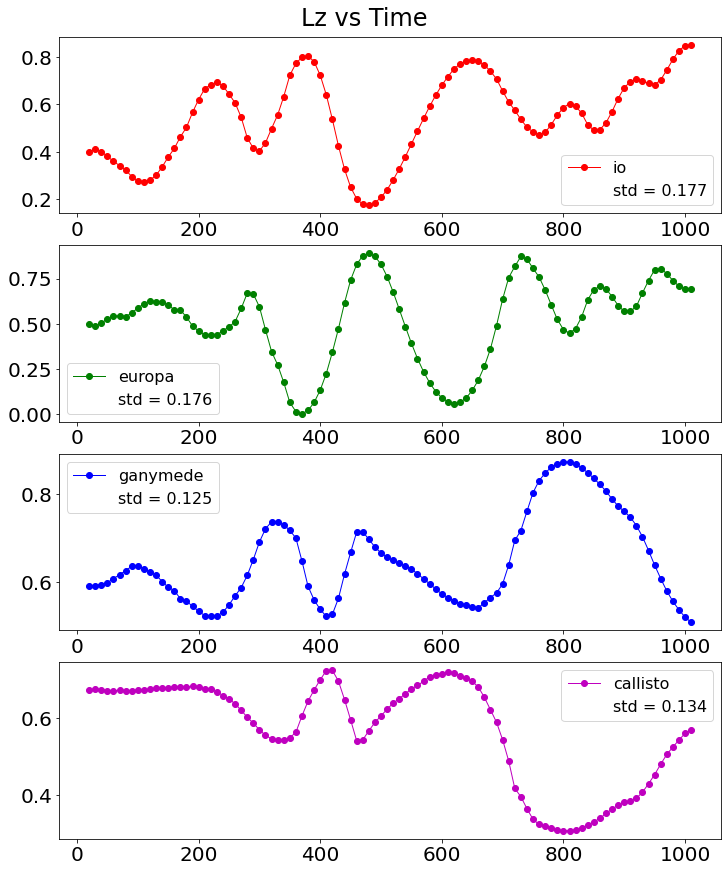

Runtime: 0.515578031539917 seconds


In [8]:
lz = check_lz(ecc, inc, moons)